<a href="https://colab.research.google.com/github/kinjuk/market-analysis/blob/main/vix-strategies/spy-vix/vix_spy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  2 of 2 completed
<ipython-input-3-3320096985>:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.024863176444390813' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[data.index[current_idx], 'Trade_Return'] = ret_pct / 100  # convert to decimal
<ipython-input-3-3320096985>:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Entry_Price'].ffi

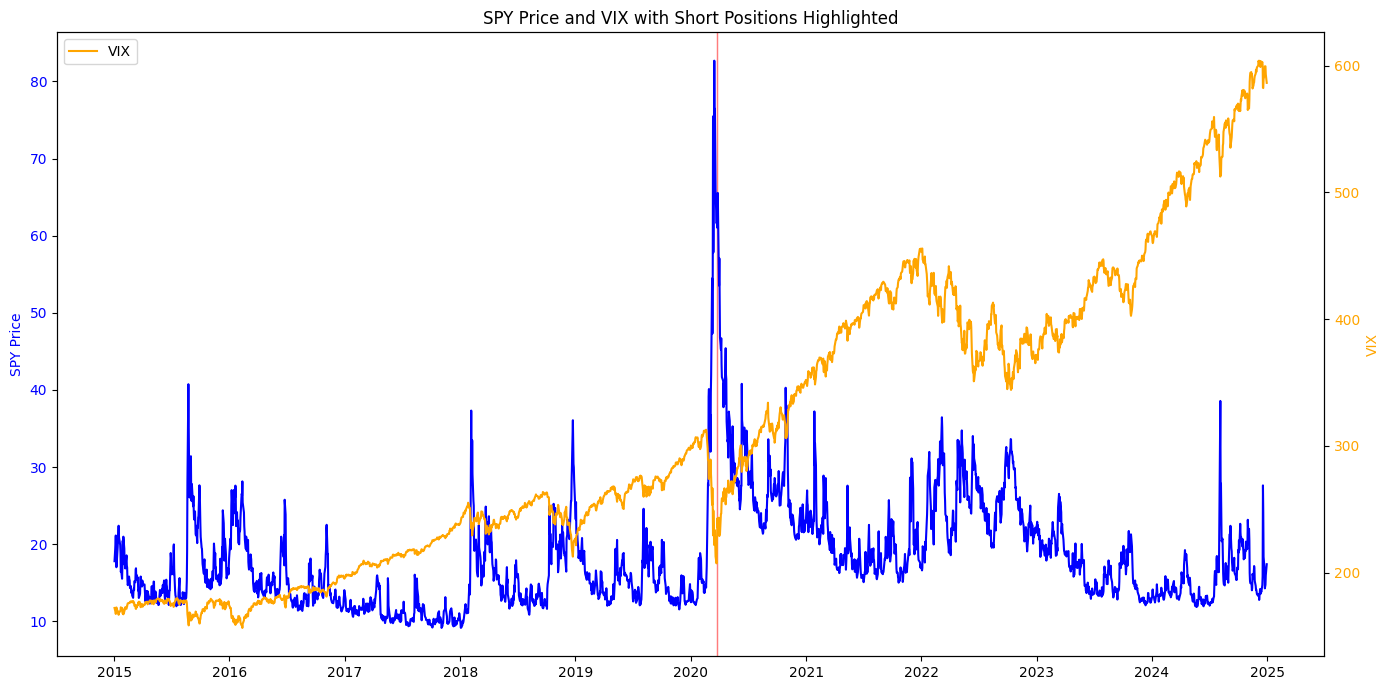

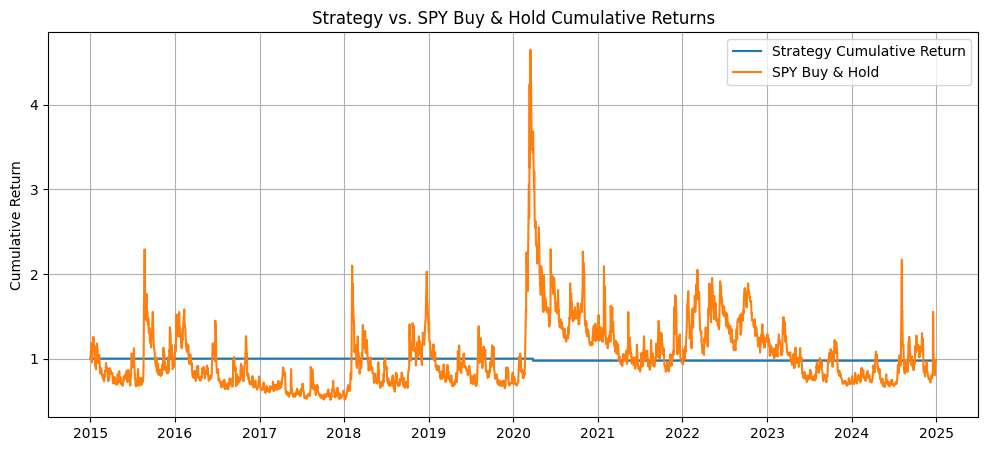

Total trades: 2515
Winning trades: 0
Losing trades: 2515
Win rate: 0.00%
Total strategy return: -2.49%


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Download data
tickers = ['^VIX', 'SPY']
data = yf.download(tickers, start='2015-01-01', end='2024-12-31', auto_adjust=True)['Close']
data.columns = ['VIX', 'SPY']

# 2. Calculate daily % changes
data['VIX_pct'] = data['VIX'].pct_change() * 100
data['SPY_pct'] = data['SPY'].pct_change() * 100

# Parameters
VIX_RISE_THRESHOLD = 5     # VIX rise % to signal fear spike
SPY_FALL_THRESHOLD = 0    # SPY max drop % for signal
SPY_RECOVER_EXIT = 0.5       # SPY gain % to exit
VIX_DROP_EXIT = -0.5         # VIX drop % to exit
MAX_HOLD_DAYS = 10          # max holding period
STOP_LOSS = -2             # stop loss % from entry price

# Prepare columns
data['Position'] = 0  # 0 = flat, -1 = short SPY
data['Entry_Price'] = np.nan
data['Exit_Price'] = np.nan
data['Trade_Return'] = 0
data['In_Trade'] = False
data['Days_In_Trade'] = 0

# 3. Backtesting loop
in_trade = False
entry_idx = None
entry_price = None

for i in range(1, len(data)):
    if not in_trade:
        # Check entry signal: VIX up ≥5% AND SPY down ≥-1%
        if (data['VIX_pct'].iloc[i] >= VIX_RISE_THRESHOLD) and (data['SPY_pct'].iloc[i] > SPY_FALL_THRESHOLD):
            data.at[data.index[i+1] if i+1 < len(data) else data.index[i], 'Position'] = -1  # Enter short next day
            in_trade = True
            entry_idx = i + 1 if i + 1 < len(data) else i
            entry_price = data['SPY'].iloc[entry_idx]
            data.at[data.index[entry_idx], 'Entry_Price'] = entry_price
            data.at[data.index[entry_idx], 'In_Trade'] = True
            data.at[data.index[entry_idx], 'Days_In_Trade'] = 1
    else:
        # In trade: check exit conditions
        current_idx = i
        current_price = data['SPY'].iloc[current_idx]
        days_held = data['Days_In_Trade'].iloc[current_idx - 1] + 1

        # Update days in trade and flag
        data.at[data.index[current_idx], 'In_Trade'] = True
        data.at[data.index[current_idx], 'Days_In_Trade'] = days_held
        data.at[data.index[current_idx], 'Position'] = -1

        # Calculate return from entry
        ret_pct = (entry_price - current_price) / entry_price * 100

        # Exit logic:
        # 1) SPY recovers > +1%
        spy_recover = (current_price - entry_price) / entry_price * 100 >= SPY_RECOVER_EXIT
        # 2) VIX drops at least 1%
        vix_drop = data['VIX_pct'].iloc[current_idx] <= VIX_DROP_EXIT
        # 3) Max holding period reached
        max_days = days_held >= MAX_HOLD_DAYS
        # 4) Stop loss hit
        stop_loss_hit = ret_pct <= STOP_LOSS

        if spy_recover or vix_drop or max_days or stop_loss_hit:
            data.at[data.index[current_idx], 'Exit_Price'] = current_price
            data.at[data.index[current_idx], 'Trade_Return'] = ret_pct / 100  # convert to decimal
            data.at[data.index[current_idx], 'Position'] = 0
            in_trade = False
            entry_idx = None
            entry_price = None

# Forward fill Entry_Price and In_Trade columns for plotting
data['Entry_Price'].ffill(inplace=True)
data['In_Trade'].fillna(False, inplace=True)

# 4. Calculate Strategy returns series
data['Strategy_Return'] = 0.0

# Assign returns only on exit days
exit_days = data['Exit_Price'].notna()
data.loc[exit_days, 'Strategy_Return'] = data.loc[exit_days, 'Trade_Return']

# Calculate cumulative returns (assuming reinvestment)
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod().fillna(method='ffill').fillna(1)

# SPY Buy & Hold cumulative return for comparison
data['SPY_Return'] = data['SPY'].pct_change().fillna(0)
data['Cumulative_SPY'] = (1 + data['SPY_Return']).cumprod()

# 5. Visualize: Price, VIX, and Strategy zones
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(data.index, data['SPY'], label='SPY Price', color='blue')
ax1.set_ylabel('SPY Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Highlight short trade zones
for i in range(len(data)):
    if data['Position'].iloc[i] == -1:
        ax1.axvspan(data.index[i], data.index[i], color='red', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(data.index, data['VIX'], label='VIX', color='orange')
ax2.set_ylabel('VIX', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('SPY Price and VIX with Short Positions Highlighted')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()

# Plot cumulative returns
plt.figure(figsize=(12, 5))
plt.plot(data['Cumulative_Strategy'], label='Strategy Cumulative Return')
plt.plot(data['Cumulative_SPY'], label='SPY Buy & Hold')
plt.title('Strategy vs. SPY Buy & Hold Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# 6. Basic Performance Summary
total_trades = data['Trade_Return'].count()
winning_trades = (data['Trade_Return'] > 0).sum()
losing_trades = (data['Trade_Return'] <= 0).sum()
win_rate = winning_trades / total_trades if total_trades > 0 else 0
total_return = data['Cumulative_Strategy'].iloc[-1] - 1

print(f"Total trades: {total_trades}")
print(f"Winning trades: {winning_trades}")
print(f"Losing trades: {losing_trades}")
print(f"Win rate: {win_rate:.2%}")
print(f"Total strategy return: {total_return:.2%}")
